In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

## system
import os
import pickle
import warnings
warnings.filterwarnings("ignore")

## statistics
from scipy.stats import zscore
import statsmodels.formula.api as sm

## ML
import PyComplexHeatmap as pyc
from PyComplexHeatmap.utils import define_cmap
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


## Extra
from anndata import read_h5ad

## Load Data

In [2]:
## Load plasma-tissue paired samples
ad = read_h5ad('/screening/analysis/2024_05_03_tissue_enhanced_mrd_AS/intermediate/anndata/2024_06_28_pilot_tpb_anndata.h5ad')

## Load plasma-tissue paired samples' meta-data
columns = ["unique_sample_id", "sample_id", "age","qc_status", "histological_subtype", "flowcell", "molecule_file_path", "g360_max_maf_pct"]
meta_info = pd.read_csv("/screening/analysis/2024_05_03_tissue_enhanced_mrd_AS/resources/metadata/2024-06-23_updated_pilot_TPB_and_cf_Ep1_Epiv2p0_with_epiTFgamma.tsv", sep="\t").\
    loc[:,columns]
    
## combine meta-data
tissue_meta = ad.obs.reset_index().\
    query(' patient_id_specimen.str.endswith("__tumor_tissue") ').\
    merge(meta_info, how="left", on="unique_sample_id")

plasma_meta = ad.obs.reset_index().\
    query(' patient_id_specimen.str.endswith("__plasma_patient") ').\
    merge(meta_info, how="left", on="unique_sample_id")

plasma_tissue_meta = pd.concat([plasma_meta,tissue_meta],axis=0)
print(f"The shape of plasma-tissue meta-data before filtering is {plasma_tissue_meta.shape}")

## load plasma-tissue paired samples' region scores
plasma_tissue_lung_region_scores = pd.read_csv("/home/eforouzmand/repos/gh-eforouzmand/2024-Jul-09-Tissue-Plasma-Comparisons/tissue_plasma_lung_region_scores.tsv", sep="\t")

## Missing sample filtering
missing_patient_id_specimen = plasma_tissue_meta.query('~sample_id.isin(@plasma_tissue_lung_region_scores.run_sample_id) ').patient_id_specimen.iloc[0].split("__")[0]
missing_run_sample_id = plasma_tissue_meta.query(' patient_id_specimen.str.startswith(@missing_patient_id_specimen) ').sample_id

plasma_tissue_meta = plasma_tissue_meta.query(' ~sample_id.isin(@missing_run_sample_id) ').\
    set_index("sample_id")

print(f"Meta-data shape after filtering: {plasma_tissue_meta.shape}")

plasma_tissue_lung_region_scores = plasma_tissue_lung_region_scores.query(' ~run_sample_id.isin(@missing_run_sample_id) ').\
    set_index("run_sample_id")

print(f"Region score data shape after filtering: {plasma_tissue_lung_region_scores.shape}")

## Load clustering information of plasma-tissue pairs
plasma_tissue_cluster = pd.read_csv("/screening/notebooks/zhuang/summer_2024/data/plasma_tissue_cluster.tsv", sep="\t").\
    set_index("run_sample_id")

The shape of plasma-tissue meta-data before filtering is (50, 17)
Meta-data shape after filtering: (48, 16)
Region score data shape after filtering: (48, 3598)


In [3]:
## region meta-info
tissue_regions_meta = pd.read_csv('/screening/analysis/2024_03_29_MCD_intermediate_files/intermediate/s3_region_design/s3_v1.2b_V6_noCntrl_and_tcga_overlap_EP1_full.tsv', sep='\t')
tissue_regions_meta.head()

## lung model
s3_v4_model = pd.read_table("/home/eforouzmand/repos/gh-eforouzmand/2024-Jun-12-Lung-S3-in-region-discovery/intermediate_data/CANDIDATE_S3_Lung_-_V4.model_file.98_spec_set_on_s3_data.tsv")

## Load cancer-free & lung samples for the discovery set

In [4]:
with open('/screening/notebooks/zhuang/summer_2024/data/region_ids.pkl', 'rb') as f:
        region_ids = pickle.load(f)

with open('/screening/notebooks/zhuang/summer_2024/data/df_ldt.pkl', 'rb') as f:
        df_ldt = pickle.load(f)

df_cf = df_ldt.loc[:,["unique_sample_id","sample_group"]+region_ids].\
    query('sample_group == "cancer_free"').\
    drop("sample_group",axis=1).\
    set_index("unique_sample_id").\
    loc[:,s3_v4_model.region_id]

print(f"The shape of the cancer-free sample data from the discovery set is {df_cf.shape}")

## Mean and Std of each region in cancer-free samples
cf_means = df_cf.mean(axis=0)
cf_stds = df_cf.std(axis=0)

meta_columns = ["specimen_type","patient_id","histological_subtype"]

plasma_tissue_lung_region_scores = pd.merge(plasma_tissue_lung_region_scores, plasma_tissue_cluster[meta_columns], how="left", left_index=True, right_index=True)

The shape of the cancer-free sample data from the discovery set is (995, 3598)


## Region-specific Tissue Multiplier

In [5]:
tissue_snrs = plasma_tissue_lung_region_scores.query(' specimen_type == "tumor_tissue" ').\
    set_index("patient_id").\
    drop(["specimen_type", "histological_subtype"],axis=1).\
    apply(lambda x: (x-cf_means)/cf_stds, axis=1)

plasma_snrs = plasma_tissue_lung_region_scores.query(' specimen_type == "plasma_patient" ').\
    set_index("patient_id").\
    drop(["specimen_type", "histological_subtype"],axis=1).\
    apply(lambda x: (x-cf_means)/cf_stds, axis=1)

In [6]:
run = False
max_pval = 0.05

if run:
    ## tissue ~ plasma method
    ids = []
    slopes = []
    intercepts = []
    r_squares = []
    slope_pvals = []
    intercept_pvals = []

    ## mean(tissue_snr)/mean(plasma_snr) method
    mean_multi = pd.DataFrame()
    
    
    for region_id in tissue_snrs.columns:
        tissue = pd.DataFrame(tissue_snrs.loc[:,region_id]).\
            rename(columns={region_id:"tissue_snrs"})
    
        plasma = pd.DataFrame(plasma_snrs.loc[:,region_id]).\
            rename(columns={region_id:"plasma_snrs"})
        
        tmp = pd.merge(tissue,
                       plasma,
                       how="inner",
                       left_index=True,
                       right_index=True)
         
        ## linear regression
        model = sm.ols('tissue_snrs ~ plasma_snrs', data=tmp).fit()
        intercept, slope = model.params
        intercept_pval, slope_pval = model.pvalues
        r_squared = model.rsquared
    
        ## append
        ids.append(region_id)
        slopes.append(slope)
        intercepts.append(intercept)
        slope_pvals.append(slope_pval)
        intercept_pvals.append(intercept_pval)
        r_squares.append(r_squared)

        ## mean-based
        mean_multi = pd.concat([mean_multi, pd.DataFrame(tmp.mean(),columns=[region_id]).T])
    
    regression_multi = pd.DataFrame({"region_id": ids,
                                   "slope": slopes,
                                   "slope_pvalue": slope_pvals,
                                    "intercept": intercepts,
                                    "intercept_pvalue": intercept_pvals,
                                     "r_squared": r_squares}).\
        assign(multiplier = lambda df:np.where(df["slope_pvalue"] < max_pval, df["slope"], 1))

    regression_multi.to_csv("/screening/notebooks/zhuang/summer_2024/data/regression_tissue_region_specific_multiplier.tsv",sep="\t")

    mean_multi =  mean_multi.\
        assign(multiplier = lambda df: df["tissue_snrs"]/df["plasma_snrs"])

    mean_multi.to_csv("/screening/notebooks/zhuang/summer_2024/data/mean_tissue_region_specific_multiplier.tsv",sep="\t")

    print("save!")

else:
    regression_multi = pd.read_csv("/screening/notebooks/zhuang/summer_2024/data/regression_tissue_region_specific_multiplier.tsv",
                                sep="\t",
                               index_col = 0).\
        set_index("region_id").\
        assign(mutiplier_type = "regression")
    
    mean_multi = pd.read_csv("/screening/notebooks/zhuang/summer_2024/data/mean_tissue_region_specific_multiplier.tsv",
                             sep="\t",
                             index_col = 0).\
    assign(mutiplier_type = "average")

In [7]:
regression_multi.head()

slope  slope_pvalue  intercept  intercept_pvalue  r_squared  \
region_id                                                                     
merged_1004  1.199644      0.004345   3.260734      3.426073e-03   0.314722   
merged_1009  0.138587      0.573504   6.110972      1.001148e-09   0.014625   
merged_101   1.053882      0.031218   2.616705      6.171312e-03   0.194029   
merged_1010  1.268597      0.263946   1.091193      3.736558e-01   0.056371   
merged_1011 -0.528850      0.246265   4.540999      4.430057e-05   0.060591   

             multiplier mutiplier_type  
region_id                               
merged_1004    1.199644     regression  
merged_1009    1.000000     regression  
merged_101     1.053882     regression  
merged_1010    1.000000     regression  
merged_1011    1.000000     regression

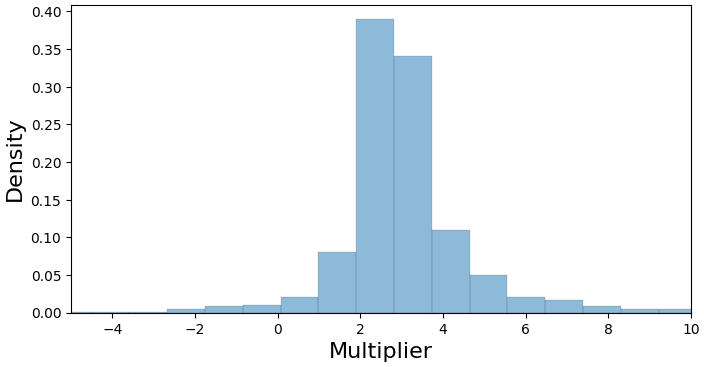

In [50]:
df = pd.concat([regression_multi, mean_multi],axis=0).\
    loc[:,["multiplier","mutiplier_type"]]

fig, axes = plt.subplots(figsize=(8,4))
    
with plt.style.context('_classic_test_patch'):
    sns.histplot(data = mean_multi,
                 x = "multiplier",
                 #hue = "mutiplier_type",
                 bins = 500,
                 kde = False,
                 alpha = 0.5,
                 stat = 'density',
                 ax = axes)
    axes.set_xlim(-5,10)
    axes.set_xlabel('Multiplier', fontsize=16)
    axes.set_ylabel('Density', fontsize=16)

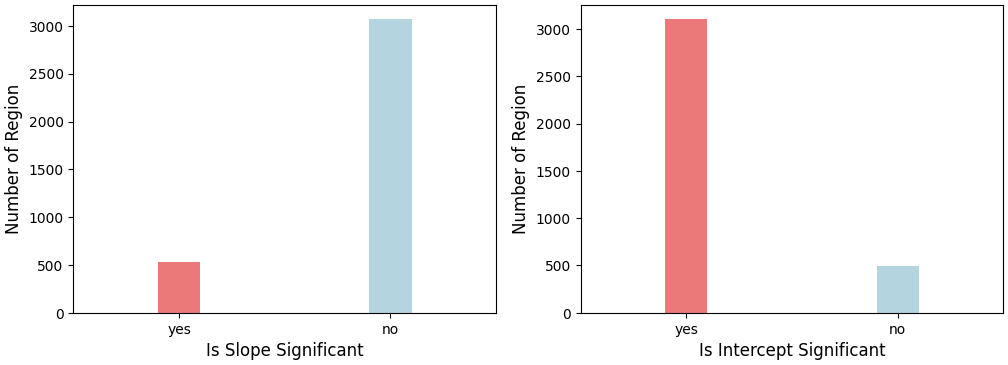

In [9]:
df = regression_multi.copy().\
    assign(minus_log10_pvalue = lambda df: -np.log10(df["slope_pvalue"]),
           is_slope_significant = lambda df: np.where(df["slope_pvalue"] <= max_pval, "yes", "no"),
           is_intercept_significant = lambda df: np.where(df["intercept_pvalue"] <= max_pval, "yes", "no"))

is_slope_significant = df.loc[:,["is_slope_significant"]].value_counts().reset_index()
is_slope_significant.columns = ["is_slope_significant","count"]

is_intercept_significant = df.loc[:,["is_intercept_significant"]].value_counts().reset_index()
is_intercept_significant.columns = ["is_intercept_significant", "count"]

custom_pallete = {"yes": "#FF6666", "no": "lightblue"}


fig, axes = plt.subplots(1,2, figsize=(12,4))
    
with plt.style.context('_classic_test_patch'):
    
    sns.barplot(data = is_slope_significant,
                 x = "is_slope_significant",
                 y = "count",
                 hue = "is_slope_significant",
                 dodge = False,
                 palette=custom_pallete,
                 order=["yes","no"],
                 width=0.2,
                 ci=None,
                 ax = axes[0])
    
    axes[0].set_xlabel('Is Slope Significant', fontsize=12)
    axes[0].set_ylabel('Number of Region', fontsize=12)

    sns.barplot(data = is_intercept_significant,
                 x = "is_intercept_significant",
                 y = "count",
                 hue = "is_intercept_significant",
                 dodge = False,
                 palette=custom_pallete,
                 order=["yes","no"],
                 width=0.2,
                 ci=None,
                 ax = axes[1])
    
    axes[1].set_xlabel('Is Intercept Significant', fontsize=12)
    axes[1].set_ylabel('Number of Region', fontsize=12)

## On-off regions using regression-based multiplier

In [10]:
thresholds = [round(i,1) for i in np.arange(0.5,5.5,0.5)]
logics = ["And","Or", "Neither", "Tissue_Only", "Plasma_Only"]
on_off_dict_regression = {}

for threshold in thresholds:
    arr = np.zeros((len(cf_means), len(logics)))
    
    for patient_id in plasma_tissue_lung_region_scores.patient_id.unique():
         
         plasma_on = pd.DataFrame(plasma_snrs.loc[patient_id ,:]).\
                        rename(columns={patient_id: "snr"}).\
                        merge(regression_multi,how="inner",left_index=True,right_index=True).\
                        assign(adj_threshold = threshold).\
                        assign(on = lambda df: np.where(df["snr"] > df["adj_threshold"], True, False)).\
                        loc[:,"on"].values
        
         tissue_on = pd.DataFrame(tissue_snrs.loc[patient_id ,:]).\
                        rename(columns={patient_id: "snr"}).\
                        merge(regression_multi,how="inner",left_index=True,right_index=True).\
                        assign(adj_threshold = lambda df: threshold*df["slope"]+df["intercept"]).\
                        assign(on = lambda df: np.where(df["snr"] > df["adj_threshold"], True, False)).\
                        loc[:,"on"].values
         

         arr[ (plasma_on) & (tissue_on) , 0] += 1
         arr[ (plasma_on) | (tissue_on), 1] += 1
         arr[ ~(plasma_on) & ~(tissue_on), 2] += 1
         arr[ ~(plasma_on) & (tissue_on), 3] += 1
         arr[ (plasma_on) & ~(tissue_on), 4] += 1

    arr = arr/len(plasma_tissue_lung_region_scores.patient_id.unique())
    on_off_dict_regression["snr_"+str(threshold)] = pd.DataFrame(arr,
                                                                 index = regression_multi.index,
                                                                 columns = logics)

In [11]:
on_off_dict_regression["snr_0.5"].head()

And        Or   Neither  Tissue_Only  Plasma_Only
region_id                                                          
merged_1004  0.875000  1.000000  0.000000     0.000000     0.125000
merged_1009  0.625000  0.958333  0.041667     0.000000     0.333333
merged_101   0.625000  0.958333  0.041667     0.083333     0.250000
merged_1010  0.416667  0.833333  0.166667     0.083333     0.333333
merged_1011  0.416667  1.000000  0.000000     0.083333     0.500000

## On-off regions using mean-based multiplier

In [12]:
on_off_dict_mean = {}

for threshold in thresholds:
    arr = np.zeros((len(cf_means), len(logics)))
    
    for patient_id in plasma_tissue_lung_region_scores.patient_id.unique():
         
         plasma_aligned, _ = plasma_snrs.loc[patient_id,:].align(mean_multi.multiplier)
         tissue_aligned, multiplier_aligned = tissue_snrs.loc[patient_id,:].align(mean_multi.multiplier)

         plasma_on = (plasma_aligned >= threshold)
         tissue_on = (tissue_aligned >= threshold * multiplier_aligned)

         arr[ (plasma_on) & (tissue_on) , 0] += 1
         arr[ (plasma_on) | (tissue_on), 1] += 1
         arr[ ~(plasma_on) & ~(tissue_on), 2] += 1
         arr[ ~(plasma_on) & (tissue_on), 3] += 1
         arr[ (plasma_on) & ~(tissue_on), 4] += 1

    arr = arr/len(plasma_tissue_lung_region_scores.patient_id.unique())
    on_off_dict_mean["snr_"+str(threshold)] = pd.DataFrame(arr,
                                                           index = mean_multi.index,
                                                           columns = logics)

In [13]:
on_off_dict_mean["snr_0.5"].head()

And        Or   Neither  Tissue_Only  Plasma_Only
merged_1004  0.958333  1.000000  0.000000     0.000000     0.041667
merged_1009  0.958333  1.000000  0.000000     0.041667     0.000000
merged_101   0.750000  0.958333  0.041667     0.083333     0.125000
merged_1010  0.416667  0.833333  0.166667     0.083333     0.333333
merged_1011  0.708333  1.000000  0.000000     0.083333     0.208333

## Count number of regions that are:

- both on: > frequency_threshold or < frequency_threshold
- either on: > frequency_threshold or < frequency_threshold
- neither on: > frequency_threshold or < frequency_threshold
- tissue only on: > frequency_threshold or < frequency_threshold
- plasma only on: frequency_threshold or < frequency_threshold

### Regression-based multiplier

In [14]:
freq_threshold_low = 0.2
freq_threshold_high = 0.8

And_count_low = []
And_count_high = []

Or_count_low = []
Or_count_high = []

Neither_count_low = []
Neither_count_high = []

Tissue_Only_count_low = []
Tissue_Only_count_high = []

Plasma_Only_count_low = []
Plasma_Only_count_high = []
    

for key, value in on_off_dict_regression.items():
        
    #threshold = float(key.split("_")[1])
    
    And_count_low.append(len(value.query('And <= @freq_threshold_low and And > 0')))
    And_count_high.append(len(value.query('And >= @freq_threshold_high')))

    Or_count_low.append(len(value.query('Or <= @freq_threshold_low and Or > 0')))
    Or_count_high.append(len(value.query('Or >= @freq_threshold_high')))

    Neither_count_low.append(len(value.query('Neither <= @freq_threshold_low and Neither > 0')))
    Neither_count_high.append(len(value.query('Neither >= @freq_threshold_high')))

    Tissue_Only_count_low.append(len(value.query('Tissue_Only <= @freq_threshold_low and Tissue_Only > 0')))
    Tissue_Only_count_high.append(len(value.query('Tissue_Only >= @freq_threshold_high')))

    Plasma_Only_count_low.append(len(value.query('Plasma_Only <= @freq_threshold_low and Plasma_Only > 0')))
    Plasma_Only_count_high.append(len(value.query('Plasma_Only >= @freq_threshold_high')))

count_summary_regression_low = pd.DataFrame({"snr_threshold":[round(i,1) for i in np.arange(0.5,5.5,0.5)],
                                   "And_count": np.array(And_count_low),
                                   "Or_count": np.array(Or_count_low),
                                   "Neither_count": np.array(Neither_count_low),          
                                   "Tissue_Only_count": np.array(Tissue_Only_count_low),
                                   "Plasma_Only_count": np.array(Plasma_Only_count_low)}).\
    assign(mutiplier_type = "regression")
    
   

count_summary_regression_high = pd.DataFrame({"snr_threshold":[round(i,1) for i in np.arange(0.5,5.5,0.5)],
                                   "And_count": np.array(And_count_high),
                                   "Or_count": np.array(Or_count_high),
                                   "Neither_count": np.array(Neither_count_low),           
                                   "Tissue_Only_count": np.array(Tissue_Only_count_high),
                                   "Plasma_Only_count": np.array(Plasma_Only_count_high)}).\
     assign(mutiplier_type = "regression")
    
   

### Mean-based multiplier

In [15]:
freq_threshold_low = 0.2
freq_threshold_high = 0.8

And_count_low = []
And_count_high = []

Or_count_low = []
Or_count_high = []

Neither_count_low = []
Neither_count_high = []

Tissue_Only_count_low = []
Tissue_Only_count_high = []

Plasma_Only_count_low = []
Plasma_Only_count_high = []
    

for key, value in on_off_dict_mean.items():
        
    #threshold = float(key.split("_")[1])
    
    And_count_low.append(len(value.query('And <= @freq_threshold_low and And > 0')))
    And_count_high.append(len(value.query('And >= @freq_threshold_high')))

    Or_count_low.append(len(value.query('Or <= @freq_threshold_low and Or > 0')))
    Or_count_high.append(len(value.query('Or >= @freq_threshold_high')))

    Neither_count_low.append(len(value.query('Neither <= @freq_threshold_low and Neither > 0')))
    Neither_count_high.append(len(value.query('Neither >= @freq_threshold_high')))

    Tissue_Only_count_low.append(len(value.query('Tissue_Only <= @freq_threshold_low and Tissue_Only > 0')))
    Tissue_Only_count_high.append(len(value.query('Tissue_Only >= @freq_threshold_high')))

    Plasma_Only_count_low.append(len(value.query('Plasma_Only <= @freq_threshold_low and Plasma_Only > 0')))
    Plasma_Only_count_high.append(len(value.query('Plasma_Only >= @freq_threshold_high')))

count_summary_mean_low = pd.DataFrame({"snr_threshold":[round(i,1) for i in np.arange(0.5,5.5,0.5)],
                                   "And_count": np.array(And_count_low),
                                   "Or_count": np.array(Or_count_low),
                                   "Neither_count": np.array(Neither_count_low),
                                   "Tissue_Only_count": np.array(Tissue_Only_count_low),
                                   "Plasma_Only_count": np.array(Plasma_Only_count_low)}).\
     assign(mutiplier_type = "average")
    
   

count_summary_mean_high = pd.DataFrame({"snr_threshold":[round(i,1) for i in np.arange(0.5,5.5,0.5)],
                                   "And_count": np.array(And_count_high),
                                   "Or_count": np.array(Or_count_high),
                                   "Neither_count": np.array(Neither_count_low),     
                                   "Tissue_Only_count": np.array(Tissue_Only_count_high),
                                   "Plasma_Only_count": np.array(Plasma_Only_count_high)}).\
     assign(mutiplier_type = "average")
    

### Visualization

In [16]:
count_summary_low = pd.concat([count_summary_regression_low, count_summary_mean_low], axis=0)
count_summary_low.head()

snr_threshold  And_count  Or_count  Neither_count  Tissue_Only_count  \
0            0.5        241         2           1659               2024   
1            1.0        416        16           1816               2297   
2            1.5        815        33           1009               1222   
3            2.0       1928        62            272                447   
4            2.5       2671       122             71                324   

   Plasma_Only_count mutiplier_type  
0                511     regression  
1                898     regression  
2               1777     regression  
3               2636     regression  
4               2182     regression

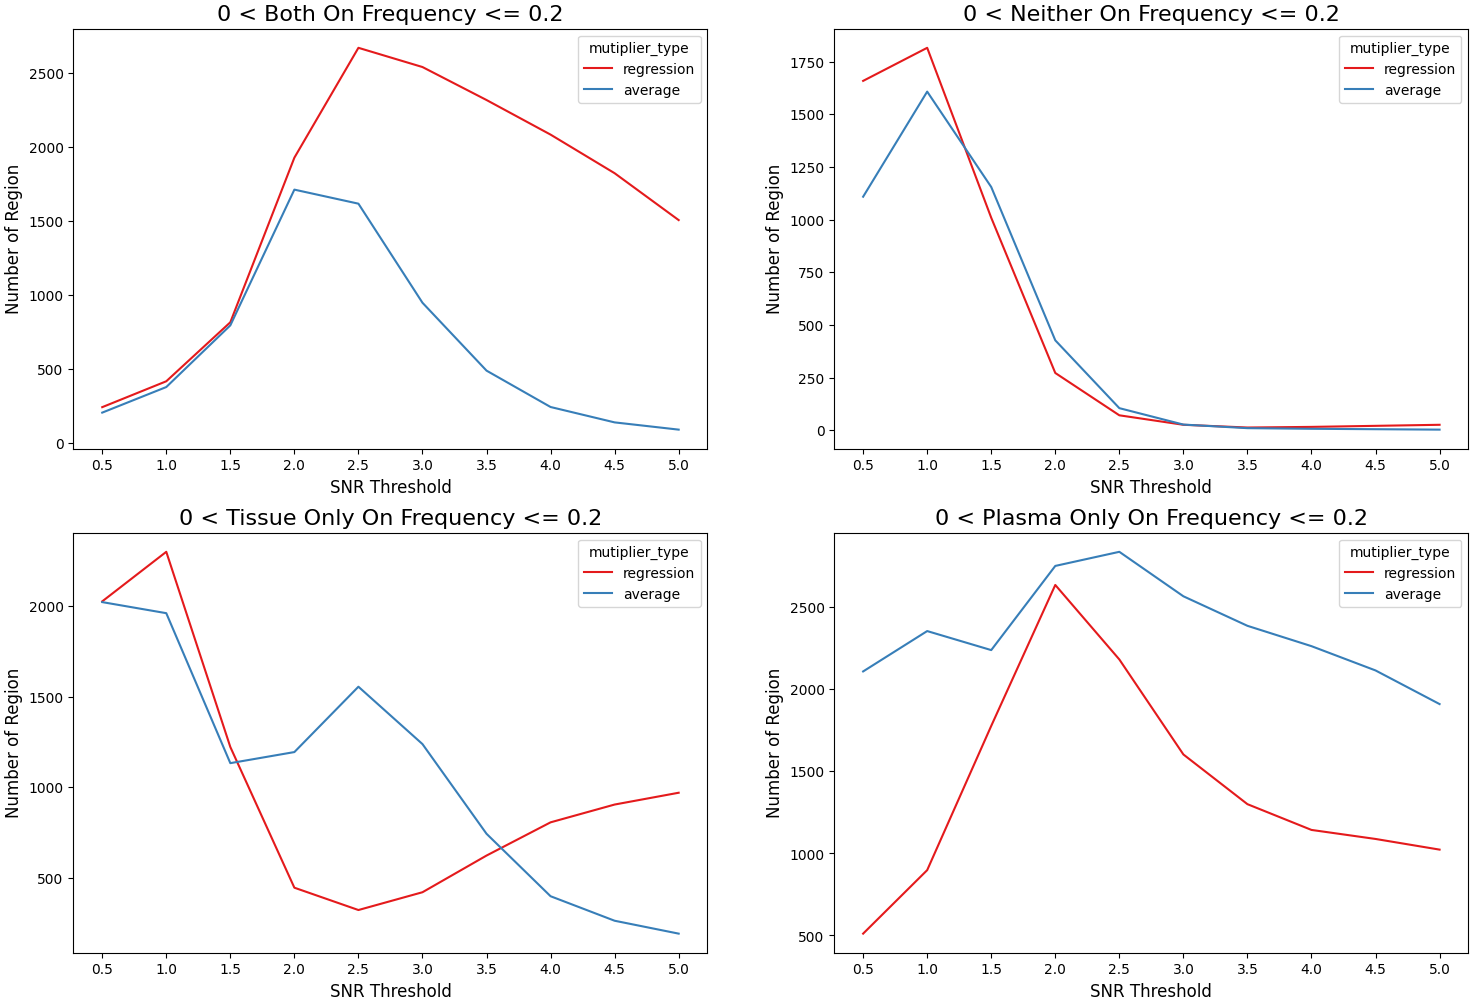

In [17]:
fig, axes = plt.subplots(2,2,figsize=(18,12))
        
with plt.style.context('_classic_test_patch'):
        
    sns.lineplot(x="snr_threshold",
                 y="And_count",
                 hue="mutiplier_type",
                 palette="Set1",
                 data=count_summary_low ,
                 ax=axes[0,0])
    
    axes[0,0].set_title(f"0 < Both On Frequency <= {freq_threshold_low:.1f}",fontsize=16)
    axes[0,0].set_xticks(thresholds)
    axes[0,0].set_xlabel("SNR Threshold", fontsize=12)
    axes[0,0].set_ylabel("Number of Region", fontsize=12)

    sns.lineplot(x="snr_threshold",
                 y="Neither_count",
                 hue="mutiplier_type",
                 palette="Set1",
                 data=count_summary_low,
                 ax=axes[0,1])
    
    axes[0,1].set_title(f"0 < Neither On Frequency <= {freq_threshold_low:.1f}", fontsize=16)
    axes[0,1].set_xticks(thresholds)
    axes[0,1].set_xlabel("SNR Threshold", fontsize=12)
    axes[0,1].set_ylabel("Number of Region", fontsize=12)

    sns.lineplot(x="snr_threshold",
                 y="Tissue_Only_count",
                 hue="mutiplier_type",
                 palette="Set1",
                 data=count_summary_low,
                 ax=axes[1,0])
    
    axes[1,0].set_title(f"0 < Tissue Only On Frequency <= {freq_threshold_low:.1f}", fontsize=16)
    axes[1,0].set_xticks(thresholds)
    axes[1,0].set_xlabel("SNR Threshold", fontsize=12)
    axes[1,0].set_ylabel("Number of Region", fontsize=12)

    sns.lineplot(x="snr_threshold",
                 y="Plasma_Only_count",
                 hue="mutiplier_type",
                 palette="Set1",
                 data=count_summary_low,
                 ax=axes[1,1])
    
    axes[1,1].set_title(f"0 < Plasma Only On Frequency <= {freq_threshold_low:.1f}", fontsize=16)
    axes[1,1].set_xticks(thresholds)
    axes[1,1].set_xlabel("SNR Threshold", fontsize=12)
    axes[1,1].set_ylabel("Number of Region", fontsize=12)

In [18]:
count_summary_high = pd.concat([count_summary_regression_high, count_summary_mean_high], axis=0)
count_summary_high.head()

snr_threshold  And_count  Or_count  Neither_count  Tissue_Only_count  \
0            0.5         52      2899           1659                  2   
1            1.0          4      2256           1816                 11   
2            1.5          0      1089           1009                 23   
3            2.0          0       313            272                 36   
4            2.5          0       119             71                 50   

   Plasma_Only_count mutiplier_type  
0                  1     regression  
1                  0     regression  
2                  0     regression  
3                  0     regression  
4                  0     regression

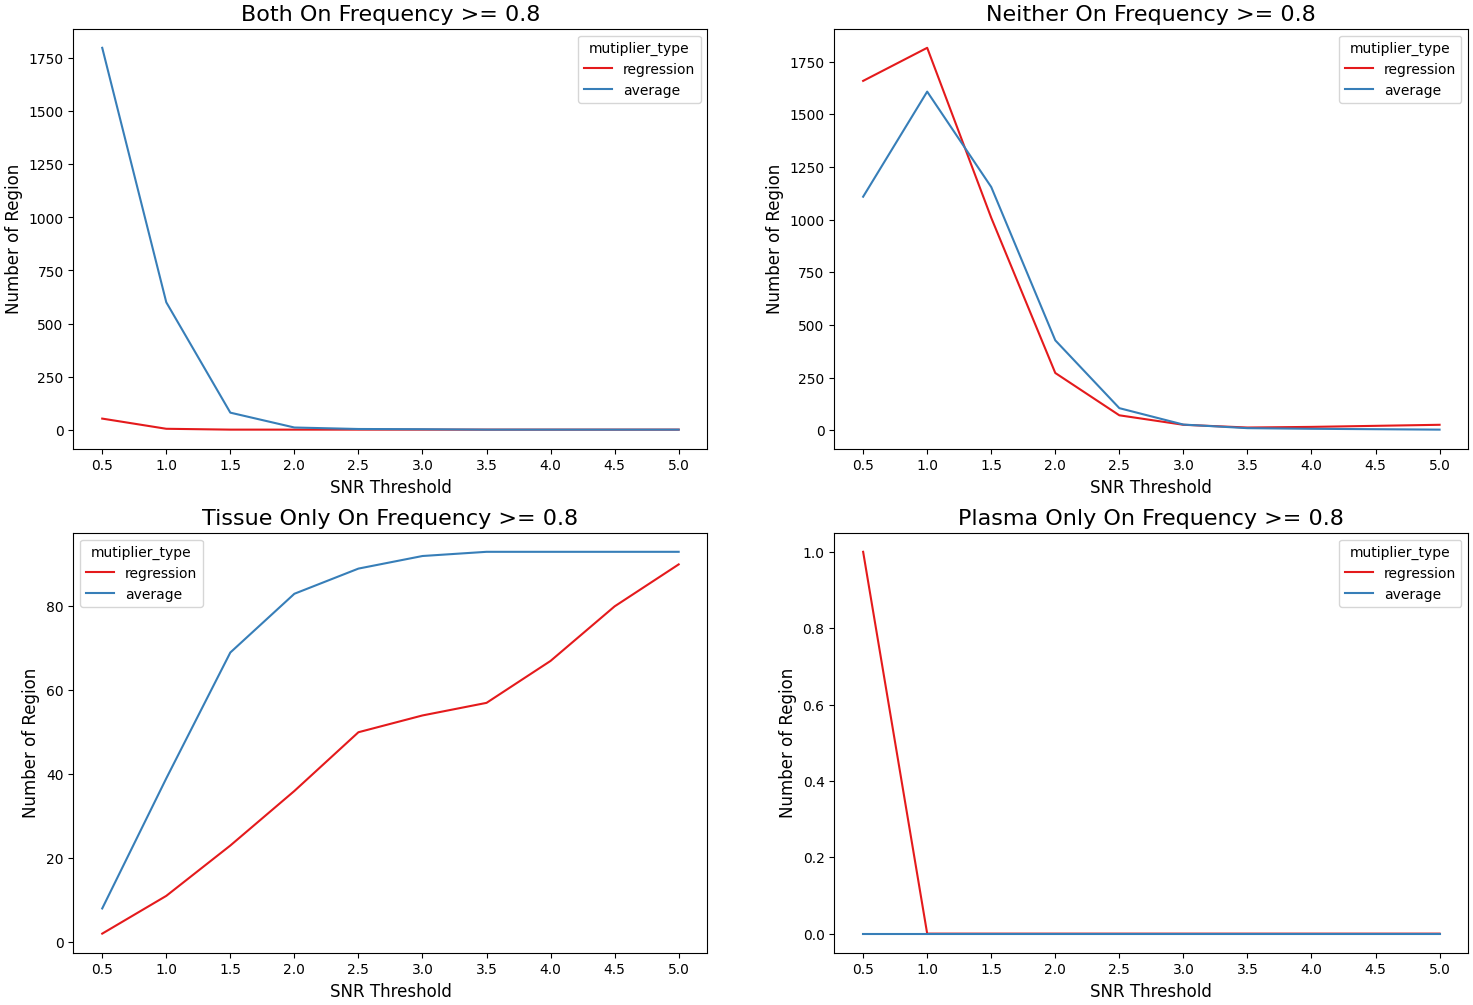

In [19]:
fig, axes = plt.subplots(2,2,figsize=(18,12))
        
with plt.style.context('_classic_test_patch'):
        
    sns.lineplot(x="snr_threshold",
                 y="And_count",
                 hue="mutiplier_type",
                 palette="Set1",
                 data=count_summary_high ,
                 ax=axes[0,0])
    
    axes[0,0].set_title(f"Both On Frequency >= {freq_threshold_high:.1f}",fontsize=16)
    axes[0,0].set_xticks(thresholds)
    axes[0,0].set_xlabel("SNR Threshold", fontsize=12)
    axes[0,0].set_ylabel("Number of Region", fontsize=12)

    sns.lineplot(x="snr_threshold",
                 y="Neither_count",
                 hue="mutiplier_type",
                 palette="Set1",
                 data=count_summary_high,
                 ax=axes[0,1])
    
    axes[0,1].set_title(f"Neither On Frequency >= {freq_threshold_high:.1f}", fontsize=16)
    axes[0,1].set_xticks(thresholds)
    axes[0,1].set_xlabel("SNR Threshold", fontsize=12)
    axes[0,1].set_ylabel("Number of Region", fontsize=12)

    sns.lineplot(x="snr_threshold",
                 y="Tissue_Only_count",
                 hue="mutiplier_type",
                 palette="Set1",
                 data=count_summary_high,
                 ax=axes[1,0])
    
    axes[1,0].set_title(f"Tissue Only On Frequency >= {freq_threshold_high:.1f}", fontsize=16)
    axes[1,0].set_xticks(thresholds)
    axes[1,0].set_xlabel("SNR Threshold", fontsize=12)
    axes[1,0].set_ylabel("Number of Region", fontsize=12)

    sns.lineplot(x="snr_threshold",
                 y="Plasma_Only_count",
                 hue="mutiplier_type",
                 palette="Set1",
                 data=count_summary_high,
                 ax=axes[1,1])
    
    axes[1,1].set_title(f"Plasma Only On Frequency >= {freq_threshold_high:.1f}", fontsize=16)
    axes[1,1].set_xticks(thresholds)
    axes[1,1].set_xlabel("SNR Threshold", fontsize=12)
    axes[1,1].set_ylabel("Number of Region", fontsize=12)

## Jaccard similarity of On-off regions between plasma and tissue

### Regression-based

In [20]:
similarity_regression = pd.DataFrame()


for threshold in thresholds:
    jaccard = []
    
    for patient_id in plasma_tissue_lung_region_scores.patient_id.unique():
         
        plasma_on = pd.DataFrame(plasma_snrs.loc[patient_id ,:]).\
                        rename(columns={patient_id: "snr"}).\
                        merge(regression_multi,how="inner",left_index=True,right_index=True).\
                        assign(adj_threshold = threshold).\
                        assign(on = lambda df: np.where(df["snr"] > df["adj_threshold"], True, False)).\
                        loc[:,"on"].values
        
        tissue_on = pd.DataFrame(tissue_snrs.loc[patient_id ,:]).\
                        rename(columns={patient_id: "snr"}).\
                        merge(regression_multi,how="inner",left_index=True,right_index=True).\
                        assign(adj_threshold = lambda df: threshold*df["slope"]+df["intercept"]).\
                        assign(on = lambda df: np.where(df["snr"] > df["adj_threshold"], True, False)).\
                        loc[:,"on"].values

        intersection = ( (plasma_on) & (tissue_on) ).sum()
        union = ( (plasma_on) | (tissue_on) ).sum()

        jaccard.append(intersection/union)
    
    similarity_regression = pd.concat([similarity_regression, pd.DataFrame(jaccard).T],axis=0)

similarity_regression.columns = plasma_tissue_lung_region_scores.patient_id.unique()
similarity_regression.index = thresholds

In [21]:
df_anno = plasma_tissue_cluster.copy()
df_anno = df_anno[["patient_id","matched", "histological_subtype"]].drop_duplicates().\
    set_index("patient_id")

similarity_regression = similarity_regression.loc[:,list(df_anno.index)]

row_anno = pd.DataFrame({"SNR_threshold":thresholds},
                         index = thresholds)

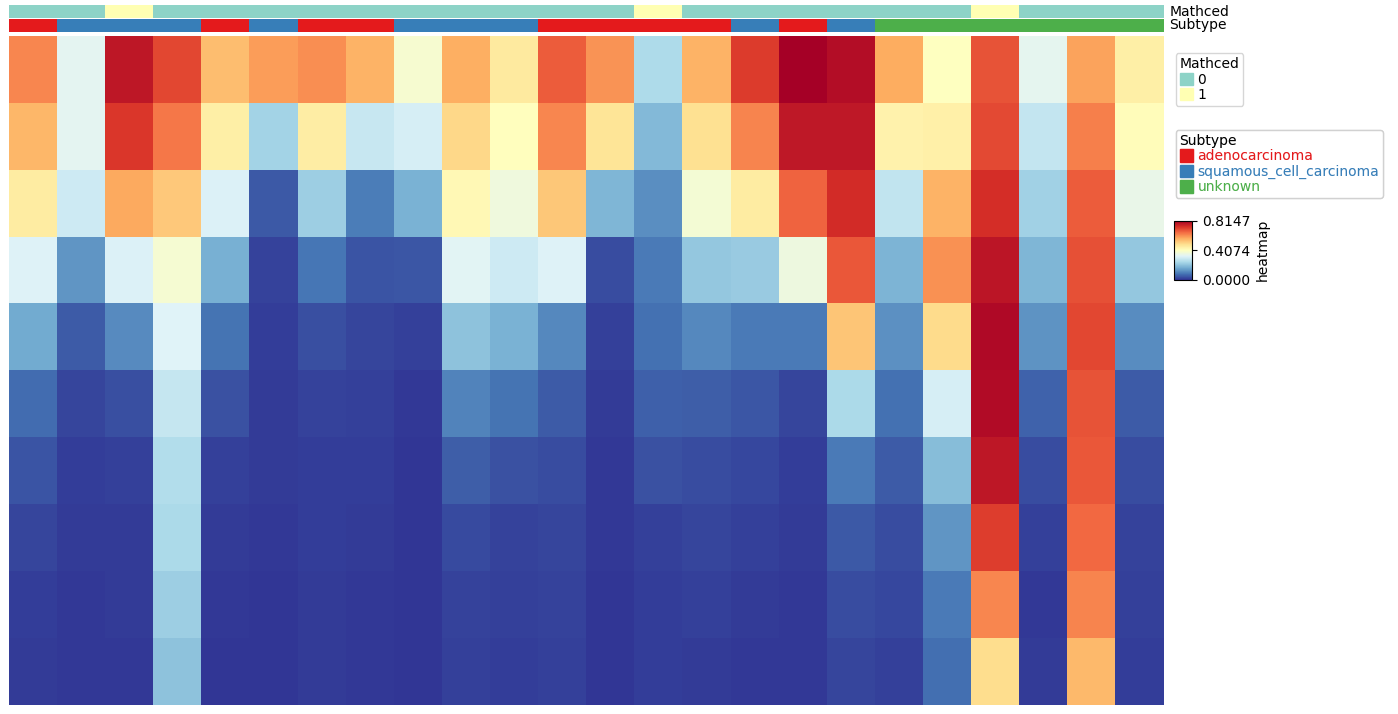

In [22]:
plt.figure(figsize=(15, 8))

# Make annotations for columns/samples
col_annot = pyc.HeatmapAnnotation(Mathced=pyc.anno_simple(df_anno.matched, cmap='Set3'),
                                  Subtype = pyc.anno_simple(df_anno.histological_subtype, cmap="Set1"),
                                  axis=1, 
                                  verbose=False)

#row_annot = pyc.HeatmapAnnotation(Threshold=pyc.anno_simple(row_anno.SNR_threshold),
                                  #axis=1, 
                                  #verbose=False)

cm = pyc.ClusterMapPlotter(data=similarity_regression, 
                           top_annotation=col_annot, 
                           #left_annotation=row_annot,
                           cmap='RdYlBu_r', 
                           col_dendrogram=False,  
                           row_dendrogram=False,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=4, 
                           col_split_gap=1, 
                           col_cluster=False,
                           row_cluster=False,
                           #row_cluster_method='complete', 
                           col_cluster_method='complete', 
                           verbose=False)

#cm.ax_heatmap.set_xticks(range(len(similarity.columns)))
#cm.ax_heatmap.set_xticklabels(similarity.columns)

#cm.ax_heatmap.set_yticks(range(len(row_anno.SNR_threshold)))
#cm.ax_heatmap.set_yticklabels(row_anno.SNR_threshold)

plt.show()

### Mean-based

In [23]:
similarity_mean = pd.DataFrame()


for threshold in thresholds:
    jaccard = []
    
    for patient_id in plasma_tissue_lung_region_scores.patient_id.unique():
         
         plasma_aligned, _ = plasma_snrs.loc[patient_id,:].align(mean_multi.multiplier)
         tissue_aligned, multiplier_aligned = tissue_snrs.loc[patient_id,:].align(mean_multi.multiplier)

         plasma_on = (plasma_aligned >= threshold)
         tissue_on = (tissue_aligned >= threshold * multiplier_aligned)

         intersection = ( (plasma_on) & (tissue_on) ).sum()
         union = ( (plasma_on) | (tissue_on) ).sum()

         jaccard.append(intersection/union)
    
    similarity_mean = pd.concat([similarity_mean, pd.DataFrame(jaccard).T],axis=0)

similarity_mean.columns = plasma_tissue_lung_region_scores.patient_id.unique()
similarity_mean.index = thresholds

In [24]:
df_anno = plasma_tissue_cluster.copy()
df_anno = df_anno[["patient_id","matched", "histological_subtype"]].drop_duplicates().\
    set_index("patient_id")

similarity_mean = similarity_mean.loc[:,list(df_anno.index)]

row_anno = pd.DataFrame({"SNR_threshold":thresholds},
                         index = thresholds)

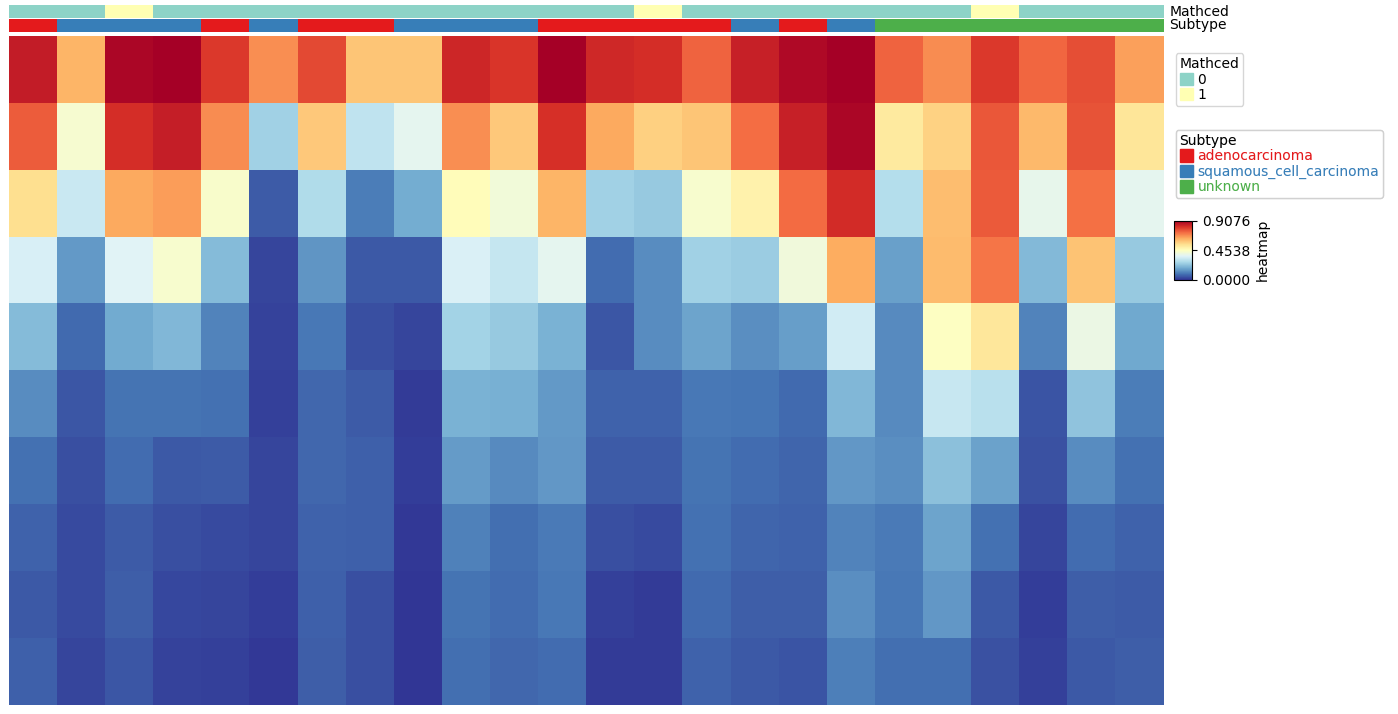

In [25]:
plt.figure(figsize=(15, 8))

# Make annotations for columns/samples
col_annot = pyc.HeatmapAnnotation(Mathced=pyc.anno_simple(df_anno.matched, cmap='Set3'),
                                  Subtype = pyc.anno_simple(df_anno.histological_subtype, cmap="Set1"),
                                  axis=1, 
                                  verbose=False)

#row_annot = pyc.HeatmapAnnotation(Threshold=pyc.anno_simple(row_anno.SNR_threshold),
                                  #axis=1, 
                                  #verbose=False)

cm = pyc.ClusterMapPlotter(data=similarity_mean, 
                           top_annotation=col_annot, 
                           #left_annotation=row_annot,
                           cmap='RdYlBu_r', 
                           col_dendrogram=False,  
                           row_dendrogram=False,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=4, 
                           col_split_gap=1, 
                           col_cluster=False,
                           row_cluster=False,
                           #row_cluster_method='complete', 
                           col_cluster_method='complete', 
                           verbose=False)

#cm.ax_heatmap.set_xticks(range(len(similarity.columns)))
#cm.ax_heatmap.set_xticklabels(similarity.columns)

#cm.ax_heatmap.set_yticks(range(len(row_anno.SNR_threshold)))
#cm.ax_heatmap.set_yticklabels(row_anno.SNR_threshold)

plt.show()

## Region classification example

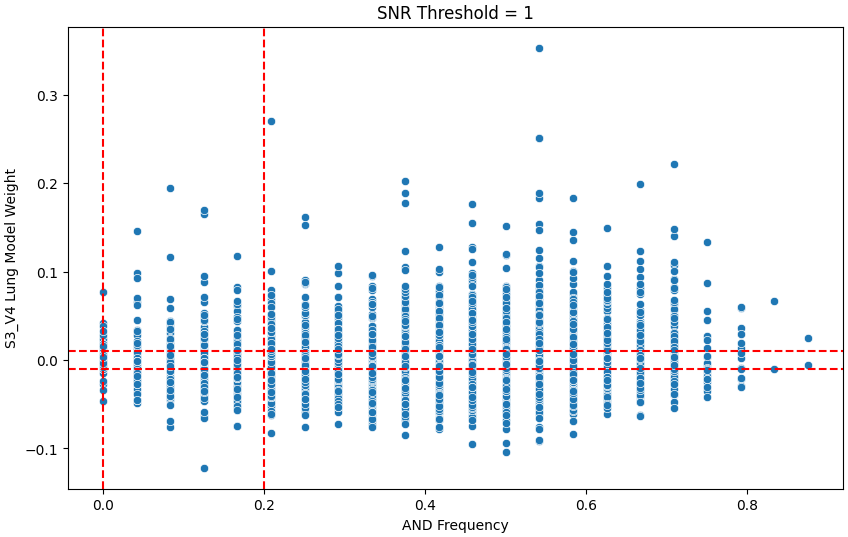

In [61]:
tmp = on_off_dict_regression['snr_1.0'].\
    reset_index(names="region_id").\
    merge(s3_v4_model, on="region_id",how='left')

abs_weight_quantile = 0.3
freq_threshold = 0.2

fig, axes = plt.subplots(figsize=(10,6))
        
with plt.style.context('_classic_test_patch'):
        
   
    sns.scatterplot(x="And",
                    y="weight",
                    data=tmp,
                    ax=axes)

    axes.set_title("SNR Threshold = 1")
    axes.set_xlabel("AND Frequency")
    axes.set_ylabel("S3_V4 Lung Model Weight")

    
    plt.axvline(freq_threshold, 0, linestyle="--", color="red")
    plt.axvline(0, 0, linestyle="--", color="red")
    plt.axhline(s3_v4_model.weight.abs().quantile(abs_weight_quantile), 0, linestyle="--", color="red")
    plt.axhline(-s3_v4_model.weight.abs().quantile(abs_weight_quantile), 0, linestyle="--", color="red")

## Region correlation (high MAF vs. low MAF)

In [51]:
## Prediction from Lung Model: MB_S3_V4
called_samples = pd.read_csv("../data/called_discovery_lung_samples.tsv",sep="\t").\
    assign(called = lambda df: np.where(df['sample_group'] == "cancer_free", "FP", "TP"))

not_called_samples = pd.read_csv("../data/not_called_discovery_lung_samples.tsv", sep="\t").\
    assign(called = lambda df: np.where(df['sample_group'] == "cancer_free", "TN", "FN"))

lung_MB_S3_V4 =  pd.concat([called_samples, not_called_samples],axis=0).\
    loc[:,["unique_sample_id","called"]].\
    set_index("unique_sample_id")

df_lung = df_ldt.loc[:,["unique_sample_id","sample_group","age","sex","histological_subtype", 'g360_max_maf_pct', 'tvf_max_maf_pct']+region_ids].\
    query('sample_group == "lung"').\
    set_index("unique_sample_id").\
    assign(histological_subtype = lambda df: np.where(df['histological_subtype'].isin(['adenocarcinoma', 'squamous_cell_carcinoma']), df['histological_subtype'], "unknown"),
          log_g360_maf = lambda df: np.log10(df['g360_max_maf_pct']),
          log_tvf_maf =  lambda df: np.log10(df['tvf_max_maf_pct']))

df_lung = pd.merge(df_lung, lung_MB_S3_V4, left_index = True, right_index = True, how = "left")

df_lung_meta = df_lung.loc[:,["sample_group","age","sex", "histological_subtype", "g360_max_maf_pct", "tvf_max_maf_pct", "log_g360_maf", "log_tvf_maf", "called"]]

df_lung = df_lung.\
     loc[:,s3_v4_model.region_id]

In [52]:
def maf_label(x, high_maf = 1, low_maf = -0.5):
    if x >= high_maf:
        return "high"
    if x <= low_maf:
        return "low"
    else:
        return "other"

### Regression-based

In [53]:
abs_weight_quantile = 0.3
freq_threshold = 0.2
region_classification_regression = {}

for key, val in on_off_dict_regression.items():
    
    val = val.\
        reset_index(names="region_id").\
        merge(s3_v4_model, on="region_id",how='left')


    ## Classify regions
    hi_freq_lo_wt = val.query('And >= @freq_threshold and weight.abs() <= weight.abs().quantile(@abs_weight_quantile) ').region_id
    hi_freq_hi_wt = val.query('And >= @freq_threshold and weight.abs() >= weight.abs().quantile(@abs_weight_quantile) ').region_id
    
    lo_freq_lo_wt = val.query('And > 0 and And <= @freq_threshold and weight.abs() <= weight.abs().quantile(@abs_weight_quantile) ').region_id
    lo_freq_hi_wt = val.query('And > 0 and And <= @freq_threshold and weight.abs() >= weight.abs().quantile(@abs_weight_quantile) ').region_id

    region_classification_regression[key] = {"hi_freq_lo_wt": hi_freq_lo_wt, ## signals in tissue that are NOT captured by the model
                                  "hi_freq_hi_wt": hi_freq_hi_wt, ## signals in tissue that are captuered by the model
                                  "lo_freq_lo_wt": lo_freq_lo_wt, ## signals in plasma that are NOT captured by the model
                                  "lo_freq_hi_wt": lo_freq_hi_wt} ## signals in plasma that are captureed by the model

### Mean-based

In [54]:
region_classification_mean = {}

for key, val in on_off_dict_regression.items():
    
    val = val.\
        reset_index(names="region_id").\
        merge(s3_v4_model, on="region_id",how='left')


    ## Classify regions
    hi_freq_lo_wt = val.query('And >= @freq_threshold and weight.abs() <= weight.abs().quantile(@abs_weight_quantile) ').region_id
    hi_freq_hi_wt = val.query('And >= @freq_threshold and weight.abs() >= weight.abs().quantile(@abs_weight_quantile) ').region_id
    
    lo_freq_lo_wt = val.query('And > 0 and And <= @freq_threshold and weight.abs() <= weight.abs().quantile(@abs_weight_quantile) ').region_id
    lo_freq_hi_wt = val.query('And > 0 and And <= @freq_threshold and weight.abs() >= weight.abs().quantile(@abs_weight_quantile) ').region_id

    region_classification_mean[key] = {"hi_freq_lo_wt": hi_freq_lo_wt, ## signals in tissue that are NOT captured by the model
                                  "hi_freq_hi_wt": hi_freq_hi_wt, ## signals in tissue that are captuered by the model
                                  "lo_freq_lo_wt": lo_freq_lo_wt, ## signals in plasma that are NOT captured by the model
                                  "lo_freq_hi_wt": lo_freq_hi_wt} ## signals in plasma that are captureed by the model

### Correlation

In [55]:
df_lung_meta = df_lung_meta.\
     assign(log10_tvf_maf = lambda df: np.log10(df["tvf_max_maf_pct"])).\
     assign(MAF = lambda df: df["log10_tvf_maf"].map(maf_label))

high_maf_id = df_lung_meta.query('MAF == "high"').index
   
print(len(high_maf_id))

low_maf_id = df_lung_meta.query('MAF == "low"').index

print(len(low_maf_id))

high_maf_region_corr = df_lung.query('index.isin(@high_maf_id)').\
    corr()

low_maf_region_corr = df_lung.query('index.isin(@low_maf_id)').\
    corr()    

123
159


### Region annotation

In [56]:
freq_threshold_low = 0.2
snr = "snr_1.0"


region_anno = pd.DataFrame({"region_id": df_lung.columns})

#.\
#assign(regression = lambda df: np.where(df['region_id'].isin(on_off_dict_regression[snr].query('And > 0 and And <= @freq_threshold_low').index), "yes","no"),
#average =   lambda df: np.where(df['region_id'].isin(on_off_dict_mean[snr].query('And > 0 and And <= @freq_threshold_low').index), "yes","no"))

region_class_regression = []
region_class_mean = []

for region in region_anno.region_id:
    
    if region in list(region_classification_regression[snr]['hi_freq_lo_wt']):
        region_class_regression.append('hi_freq_lo_wt')

    elif region in list(region_classification_regression[snr]['hi_freq_hi_wt']):
        region_class_regression.append('hi_freq_hi_wt')

    elif region in list(region_classification_regression[snr]['lo_freq_lo_wt']):
        region_class_regression.append('lo_freq_lo_wt')

    elif region in list(region_classification_regression[snr]['lo_freq_hi_wt']):
         region_class_regression.append('lo_freq_hi_wt')
    else:
        region_class_regression.append('zero_freq')

for region in region_anno.region_id:
    
    if region in list(region_classification_mean[snr]['hi_freq_lo_wt']):
        region_class_mean.append('hi_freq_lo_wt')
    
    elif region in list(region_classification_mean[snr]['hi_freq_hi_wt']):
        region_class_mean.append('hi_freq_hi_wt')
    
    
    elif region in list(region_classification_mean[snr]['lo_freq_lo_wt']):
        region_class_mean.append('lo_freq_lo_wt')
    
    elif region in list(region_classification_mean[snr]['lo_freq_hi_wt']):
         region_class_mean.append('lo_freq_hi_wt')

    else:
        region_class_mean.append('zero_freq')
region_anno = region_anno.assign(region_class_regression = region_class_regression,
                                 region_class_mean = region_class_mean).\
    assign(lo_freq_lo_wt_reg = lambda df:np.where(df["region_class_regression"] == 'lo_freq_lo_wt', "yes", "no"),
           lo_freq_lo_wt_avg = lambda df:np.where(df["region_class_mean"] == 'lo_freq_lo_wt', "yes", "no"),
           lo_freq_hi_wt_reg = lambda df:np.where(df["region_class_regression"] == 'lo_freq_hi_wt', "yes", "no"),
           lo_freq_hi_wt_avg = lambda df:np.where(df["region_class_mean"] == 'lo_freq_hi_wt', "yes", "no")).\
    set_index("region_id")

region_anno.head()

region_class_regression region_class_mean lo_freq_lo_wt_reg  \
region_id                                                                     
s3_region_26389               zero_freq         zero_freq                no   
s3_region_22508           lo_freq_lo_wt     lo_freq_lo_wt               yes   
s3_region_22604           hi_freq_hi_wt     hi_freq_hi_wt                no   
s3_region_26760               zero_freq         zero_freq                no   
s3_region_17285               zero_freq         zero_freq                no   

                lo_freq_lo_wt_avg lo_freq_hi_wt_reg lo_freq_hi_wt_avg  
region_id                                                              
s3_region_26389                no                no                no  
s3_region_22508               yes                no                no  
s3_region_22604                no                no                no  
s3_region_26760                no                no                no  
s3_region_17285                no                no                no

### High MAF samples Heatmap

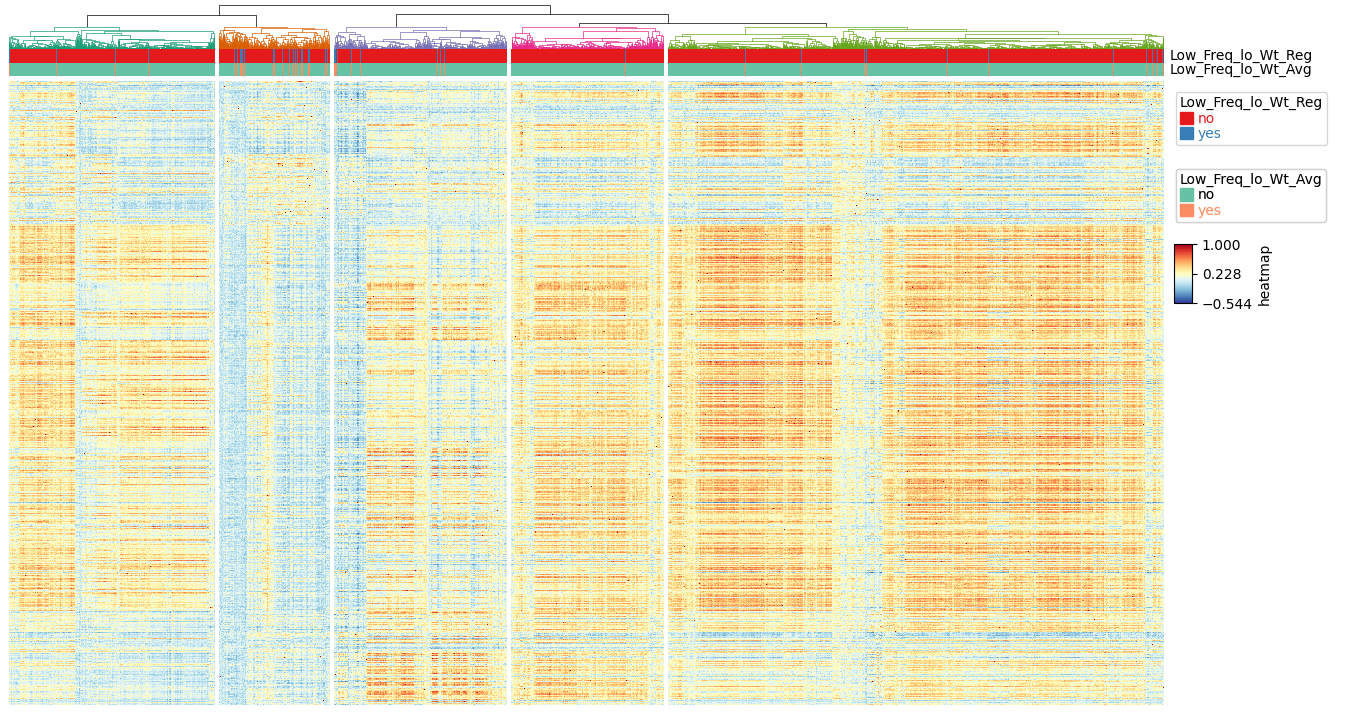

In [59]:
plt.figure(figsize=(15, 8))

# Make annotations for columns/samples
#col_annot = pyc.HeatmapAnnotation(Mathced=pyc.anno_simple(df_anno.matched, cmap='Set3'),
                                  #Subtype = pyc.anno_simple(df_anno.histological_subtype, cmap="Set1"),
                                  #axis=1, 
                                  #verbose=False)

col_annot = pyc.HeatmapAnnotation(#Personal=pyc.anno_simple(region_anno.mutiplier_1, cmap="Set2"),
                                  #Region_class = pyc.anno_simple(region_anno.region_class, cmap="Set1"),
                                  Low_Freq_lo_Wt_Reg = pyc.anno_simple(region_anno.lo_freq_lo_wt_reg, cmap="Set1"),
                                  Low_Freq_lo_Wt_Avg = pyc.anno_simple(region_anno.lo_freq_lo_wt_avg, cmap="Set2"),
                                  #Low_Freq_hi_Wt_Reg = pyc.anno_simple(region_anno.lo_freq_hi_wt_reg, cmap="Set1"),
                                  #Low_Freq_hi_Wt_Avg = pyc.anno_simple(region_anno.lo_freq_hi_wt_reg, cmap="Set2"),
                                  axis=1, 
                                  verbose=False)

cm = pyc.ClusterMapPlotter(data=high_maf_region_corr, 
                           top_annotation=col_annot, 
                           #left_annotation=row_annot,
                           cmap='RdYlBu_r', 
                           col_dendrogram=True,  
                           row_dendrogram=False,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=5, 
                           col_split_gap=1, 
                           col_cluster=True,
                           row_cluster=False,
                           row_cluster_method='complete', 
                           col_cluster_method='complete', 
                           verbose=False)

plt.show()

### Low MAF samples Heatmap

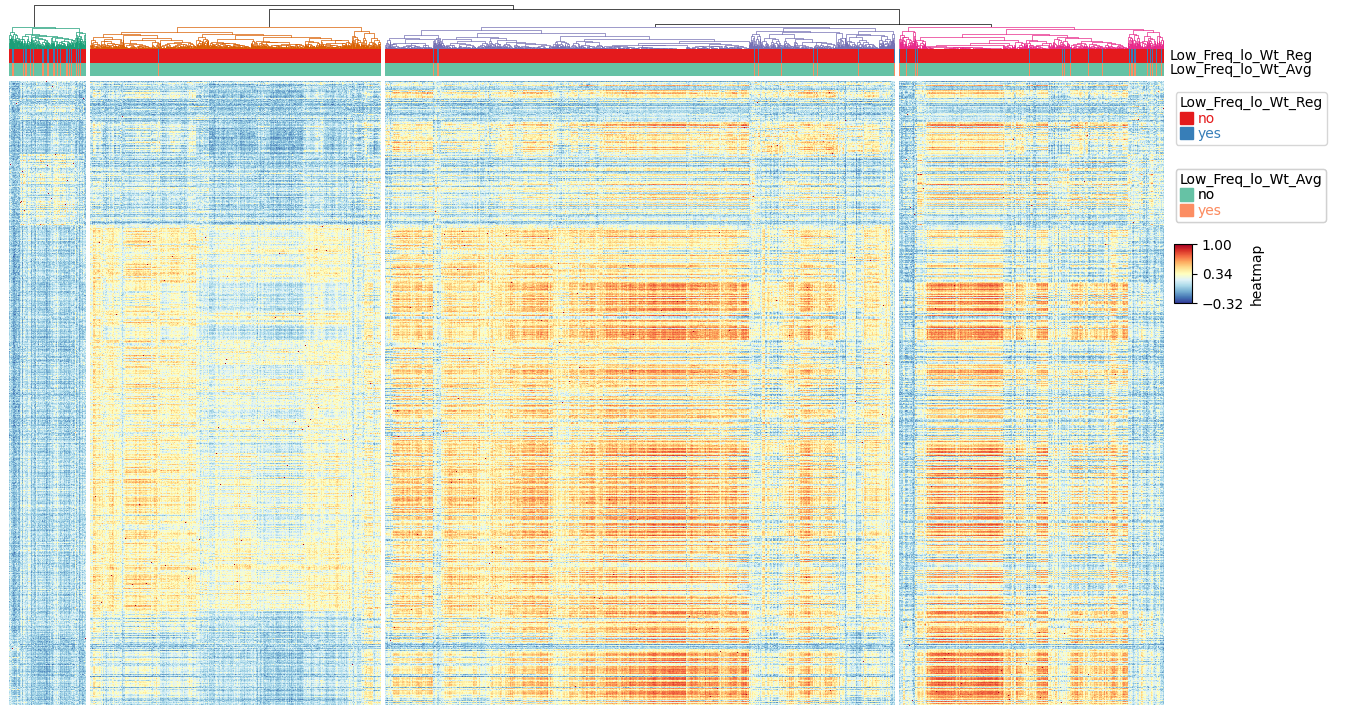

In [58]:
plt.figure(figsize=(15, 8))

# Make annotations for columns/samples
#col_annot = pyc.HeatmapAnnotation(Mathced=pyc.anno_simple(df_anno.matched, cmap='Set3'),
                                  #Subtype = pyc.anno_simple(df_anno.histological_subtype, cmap="Set1"),
                                  #axis=1, 
                                  #verbose=False)

col_annot = pyc.HeatmapAnnotation(#Personal=pyc.anno_simple(region_anno.mutiplier_1, cmap="Set2"),
                                  #Region_class = pyc.anno_simple(region_anno.region_class, cmap="Set1"),
                                  Low_Freq_lo_Wt_Reg = pyc.anno_simple(region_anno.lo_freq_lo_wt_reg, cmap="Set1"),
                                  Low_Freq_lo_Wt_Avg = pyc.anno_simple(region_anno.lo_freq_lo_wt_avg, cmap="Set2"),
                                  #Low_Freq_hi_Wt_Reg = pyc.anno_simple(region_anno.lo_freq_hi_wt_reg, cmap="Set1"),
                                  #Low_Freq_hi_Wt_Avg = pyc.anno_simple(region_anno.lo_freq_hi_wt_reg, cmap="Set2"),
                                  axis=1, 
                                  verbose=False)

cm = pyc.ClusterMapPlotter(data=low_maf_region_corr, 
                           top_annotation=col_annot, 
                           #left_annotation=row_annot,
                           cmap='RdYlBu_r', 
                           col_dendrogram=True,  
                           row_dendrogram=False,  
                           tree_kws={'col_cmap': 'Dark2'}, 
                           col_split=5, 
                           col_split_gap=1, 
                           col_cluster=True,
                           row_cluster=False,
                           row_cluster_method='complete', 
                           col_cluster_method='complete', 
                           verbose=False)

plt.show()